# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits
from astropy.visualization import simple_norm

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-11/reduced/NGC2217/aNGC2217_R.fits')
data = hdu['PRIMARY'].data

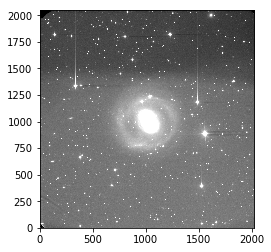

In [4]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=4, vmax=7)

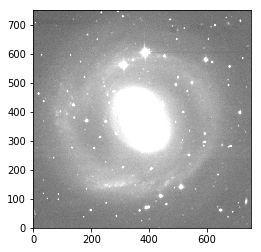

In [5]:
#cut
from astropy.nddata import Cutout2D
position = (1023, 1003)
size=(750,750)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=4, vmax=7)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [6]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

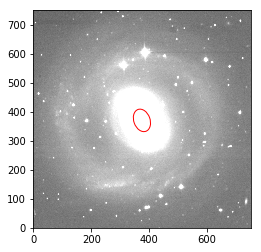

In [9]:
# how does it look?
geometry = EllipseGeometry (x0=375, y0=370, sma=40, eps=0.7,pa=110*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=4, vmax=7)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [10]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [11]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,335.025151792881,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5487684808459423,331.61166509949055,0.33940108126291046,0.07212680042086424,0.03438375718002083,178.868197924,15.1242191878,0.537098018692137,13,0,10,0
0.6036453289305366,330.983749745051,0.3810242596606875,0.07565342953857493,0.03028187433644373,178.271879561,12.7131905252,0.4521912985848231,13,0,10,0
0.6640098618235902,329.7178354176191,0.40270546472490404,0.016507007464609175,0.027743823488859048,82.0763461812,51.8437120869,0.40870762227745266,13,0,15,0
0.7304108480059492,329.1198001346884,0.39604451201681007,0.0979797018834613,0.021109902227547002,82.0763461812,6.93077883158,0.3453098398526771,13,0,10,0
0.8034519328065441,327.8235678958824,0.514169762316164,0.13493524420160088,0.019332787637823146,90.7818399807,4.70117886828,0.30964581360857873,13,0,10,0
0.8837971260871986,325.6248761846689,0.5406180311029687,0.1479294028728479,0.017519885163147276,90.6337541455,3.91257429513,0.29047124659888773,13,0,10,0
0.9721768386959185,323.11291155744277,0.5916587476643482,0.15905496194973173,0.015662228326605736,89.0719038596,3.27794870164,0.24116117351260088,13,0,10,0


Text(0,0.5,'Ellipticity')

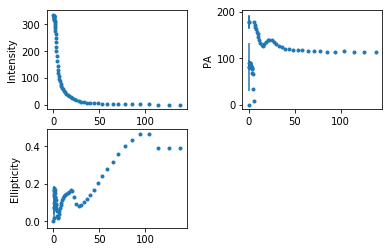

In [12]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [13]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5,1,'Residual')

<Figure size 432x288 with 0 Axes>

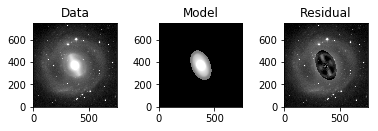

In [18]:
norm_model = simple_norm(model_image,stretch='asinh',percent=98)
norm_data = simple_norm(cutout.data,stretch='asinh',percent=98)
fig = plt.figure()
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower',norm=norm_data )
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', norm=norm_model)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', norm=norm_data)
ax3.set_title('Residual')